In [222]:
from libraries.db import DatabaseProxy
from bertopic import BERTopic
import dotenv
from bertopic.representation import OpenAI, KeyBERTInspired
import openai
import os
import pandas as pd
import matplotlib.pyplot as plt

In [223]:
# disable deprecated warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [224]:
db = DatabaseProxy(reset=True, database="eda")
dotenv.load_dotenv(".envrc")

True

In [225]:
df = pd.read_csv("input/qa-pairs.csv", encoding="latin-1")
df["id"] = df.index
db.insert_from_dataframe(df, col_questions="question", col_answers="answer")

# Basic Statistics

In [226]:
df.head()

question  \
0  Checking the financial stability of our suppli...   
1  How many candidates do you have in your database?   
2  How do you select which candidates are placed ...   
3  How often do you review and refresh your datab...   
4  What type of background and drug testing do yo...   

                                              answer  \
0  Our fiscal year begins in January and ends in ...   
1  As of today, 4/25/2023, we have the following:...   
2  Our specialized role known as the client speci...   
3  Our sourcing platform is updated throughout th...   
4  AccuSource is our service provider for backgro...   

   partners_personnel_selected  id  
0                            0   0  
1                            0   1  
2                            0   2  
3                            0   3  
4                            0   4

Number of questions

In [227]:
df.shape

(168, 4)

Question length (character and word count)

In [228]:
df["question_length"] = df["question"].apply(len)
df["question_wordcount"] = df["question"].apply(lambda x: len(x.split(" ")))

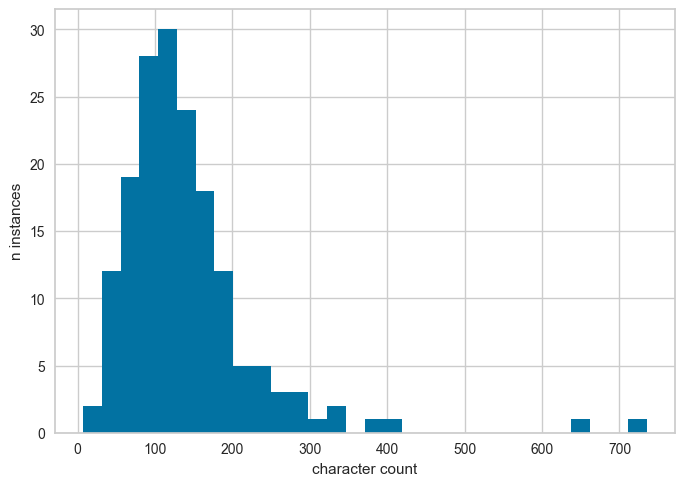

count    168.000000
mean     140.869048
std       91.372539
min        7.000000
25%       91.500000
50%      123.000000
75%      163.750000
max      735.000000
Name: question_length, dtype: float64

In [229]:
df["question_length"].hist(bins=30)
plt.xlabel("character count")
plt.ylabel("n instances")
plt.show()
df["question_length"].describe()

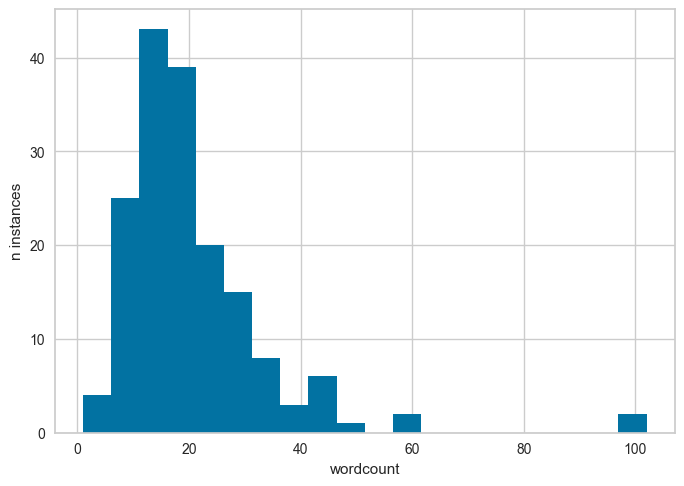

count    168.000000
mean      21.059524
std       13.481725
min        1.000000
25%       14.000000
50%       18.000000
75%       25.000000
max      102.000000
Name: question_wordcount, dtype: float64

In [230]:
df["question_wordcount"].hist(bins=20)
plt.xlabel("wordcount")
plt.ylabel("n instances")
plt.show()
df["question_wordcount"].describe()

Bundled question distribution

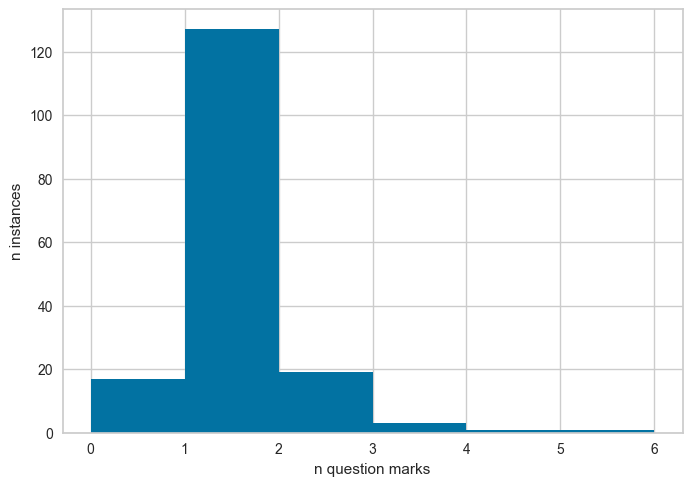

count    168.000000
mean       1.095238
std        0.694185
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: n_bundled_questions, dtype: float64

In [231]:
df["n_bundled_questions"] = df["question"].apply(lambda x: x.count("?"))
df["n_bundled_questions"].hist(bins=6)
plt.xlabel("n question marks")
plt.ylabel("n instances")
plt.show()
df["n_bundled_questions"].describe()

# Named Entity Recognizer

In [232]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [233]:
ents = []
for i, row in df.iterrows():
    question = row["question"]
    doc = nlp(question)
    ents.append([ent.lemma_.lower() for ent in doc.ents])
    if i % 16 == 0:
        displacy.render(doc, style="ent", jupyter=True)

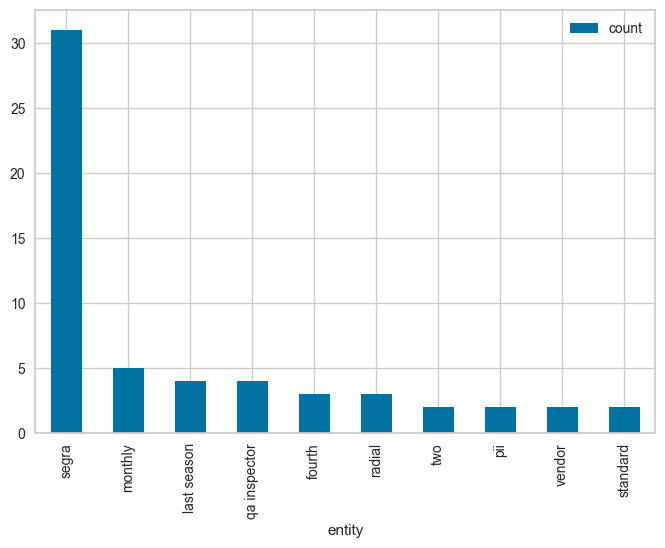

In [234]:
#bar chart of most common ent

from collections import Counter
from itertools import chain

ents = list(chain.from_iterable(ents))
ent_counts = Counter(ents)
ent_counts.most_common(10)

ent_counts_df = pd.DataFrame(ent_counts.most_common(10), columns=["entity", "count"])
ent_counts_df.plot.bar(x="entity", y="count")
plt.show()

# Topic Modeling

Uses LDA according to the following article: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

Clean data

In [235]:
# Load the regular expression library
import re

# Remove punctuation
df["question_processed"] = df["question"].map(
    lambda x: re.sub("[,\.!?]", "", x)
)
# Convert the titles to lowercase
df["question_processed"] = df["question_processed"].str.lower()
# remove extraneous whitespace
df["question_processed"] = df["question_processed"].str.strip()
# Print out the first rows of papers
df["question_processed"].head()

0    checking the financial stability of our suppli...
1     how many candidates do you have in your database
2    how do you select which candidates are placed ...
3    how often do you review and refresh your datab...
4    what type of background and drug testing do yo...
Name: question_processed, dtype: object

Prepare data for LDA analysis

In [236]:
from gensim.utils import simple_preprocess

# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use"])


def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield (simple_preprocess(str(sentence), deacc=True))


def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


data = df["question_processed"].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['checking', 'financial', 'stability', 'suppliers', 'part', 'due', 'diligence', 'process', 'support', 'us', 'please', 'tell', 'us', 'company', 'financial', 'year', 'runs']


In [237]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1)]


LDA model training

In [238]:
import gensim
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus, id2word=id2word, num_topics=num_topics
)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[(0,
  '0.023*"network" + 0.022*"access" + 0.021*"segra" + 0.017*"ensure" + '
  '0.013*"vendor" + 0.011*"internal" + 0.009*"process" + 0.009*"require" + '
  '0.009*"information" + 0.009*"changes"'),
 (1,
  '0.024*"please" + 0.018*"security" + 0.015*"review" + 0.011*"software" + '
  '0.011*"etc" + 0.010*"explain" + 0.009*"system" + 0.009*"access" + '
  '0.009*"process" + 0.009*"information"'),
 (2,
  '0.031*"access" + 0.020*"please" + 0.016*"segra" + 0.015*"company" + '
  '0.014*"provide" + 0.014*"data" + 0.010*"employees" + 0.010*"explain" + '
  '0.010*"security" + 0.009*"network"'),
 (3,
  '0.028*"segra" + 0.015*"security" + 0.015*"criminal" + 0.012*"information" + '
  '0.010*"yes" + 0.010*"please" + 0.009*"including" + 0.009*"policy" + '
  '0.009*"describe" + 0.009*"include"'),
 (4,
  '0.030*"please" + 0.027*"data" + 0.025*"explain" + 0.015*"process" + '
  '0.011*"security" + 0.008*"provide" + 0.008*"users" + 0.008*"privacy" + '
  '0.008*"user" + 0.008*"onboarding"'),
 (5,
  '0.017*"

Analyzing LDA results

In [239]:
import pyLDAvis.gensim
import pickle
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join("./output/ldavis_prepared_" + str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, "wb") as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(
    LDAvis_prepared, "./output/ldavis_prepared_" + str(num_topics) + ".html"
)
LDAvis_prepared

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.100023  0.018861       1        1  15.067025
1     -0.016257  0.047292       2        1  13.799855
2     -0.058572 -0.086835       3        1  10.852796
6     -0.056735  0.007127       4        1  10.780015
8     -0.071019  0.047087       5        1  10.490970
5      0.115521 -0.041994       6        1   9.354914
7      0.056034 -0.049586       7        1   9.287647
3      0.036533  0.020698       8        1   7.584850
0      0.014733 -0.080107       9        1   7.550588
9      0.079786  0.117458      10        1   5.231341, topic_info=             Term       Freq      Total Category  logprob  loglift
116         segra  23.000000  23.000000  Default  30.0000  30.0000
211        access  22.000000  22.000000  Default  29.0000  29.0000
287        assets   7.000000   7.000000  Default  28.0000  28.0000
235       network  11.000000  11.000000  Default  27.0000  27.0000
882  satisfaction   2.000000   2.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
180        vendor   0.601462   7.185447  Topic10  -5.2241   0.4701
451   implemented   0.601460   1.906564  Topic10  -5.2241   1.7968
229    regulatory   0.601459   2.728915  Topic10  -5.2241   1.4382
53      approvals   0.601456   3.326659  Topic10  -5.2241   1.2401
252          user   0.601452   6.389180  Topic10  -5.2241   0.5875

[606 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
192      10  0.399975        able
549       8  0.780665  acceptable
453      10  0.812088    accepted
211       1  0.089082      access
211       2  0.133623      access
...     ...       ...         ...
82        5  0.089266         yes
82        6  0.089266         yes
82        7  0.089266         yes
82        8  0.178532         yes
886      10  0.812103      youove

[838 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 3, 7, 9, 6, 8, 4, 1, 10])

# Word Frequency Analysis

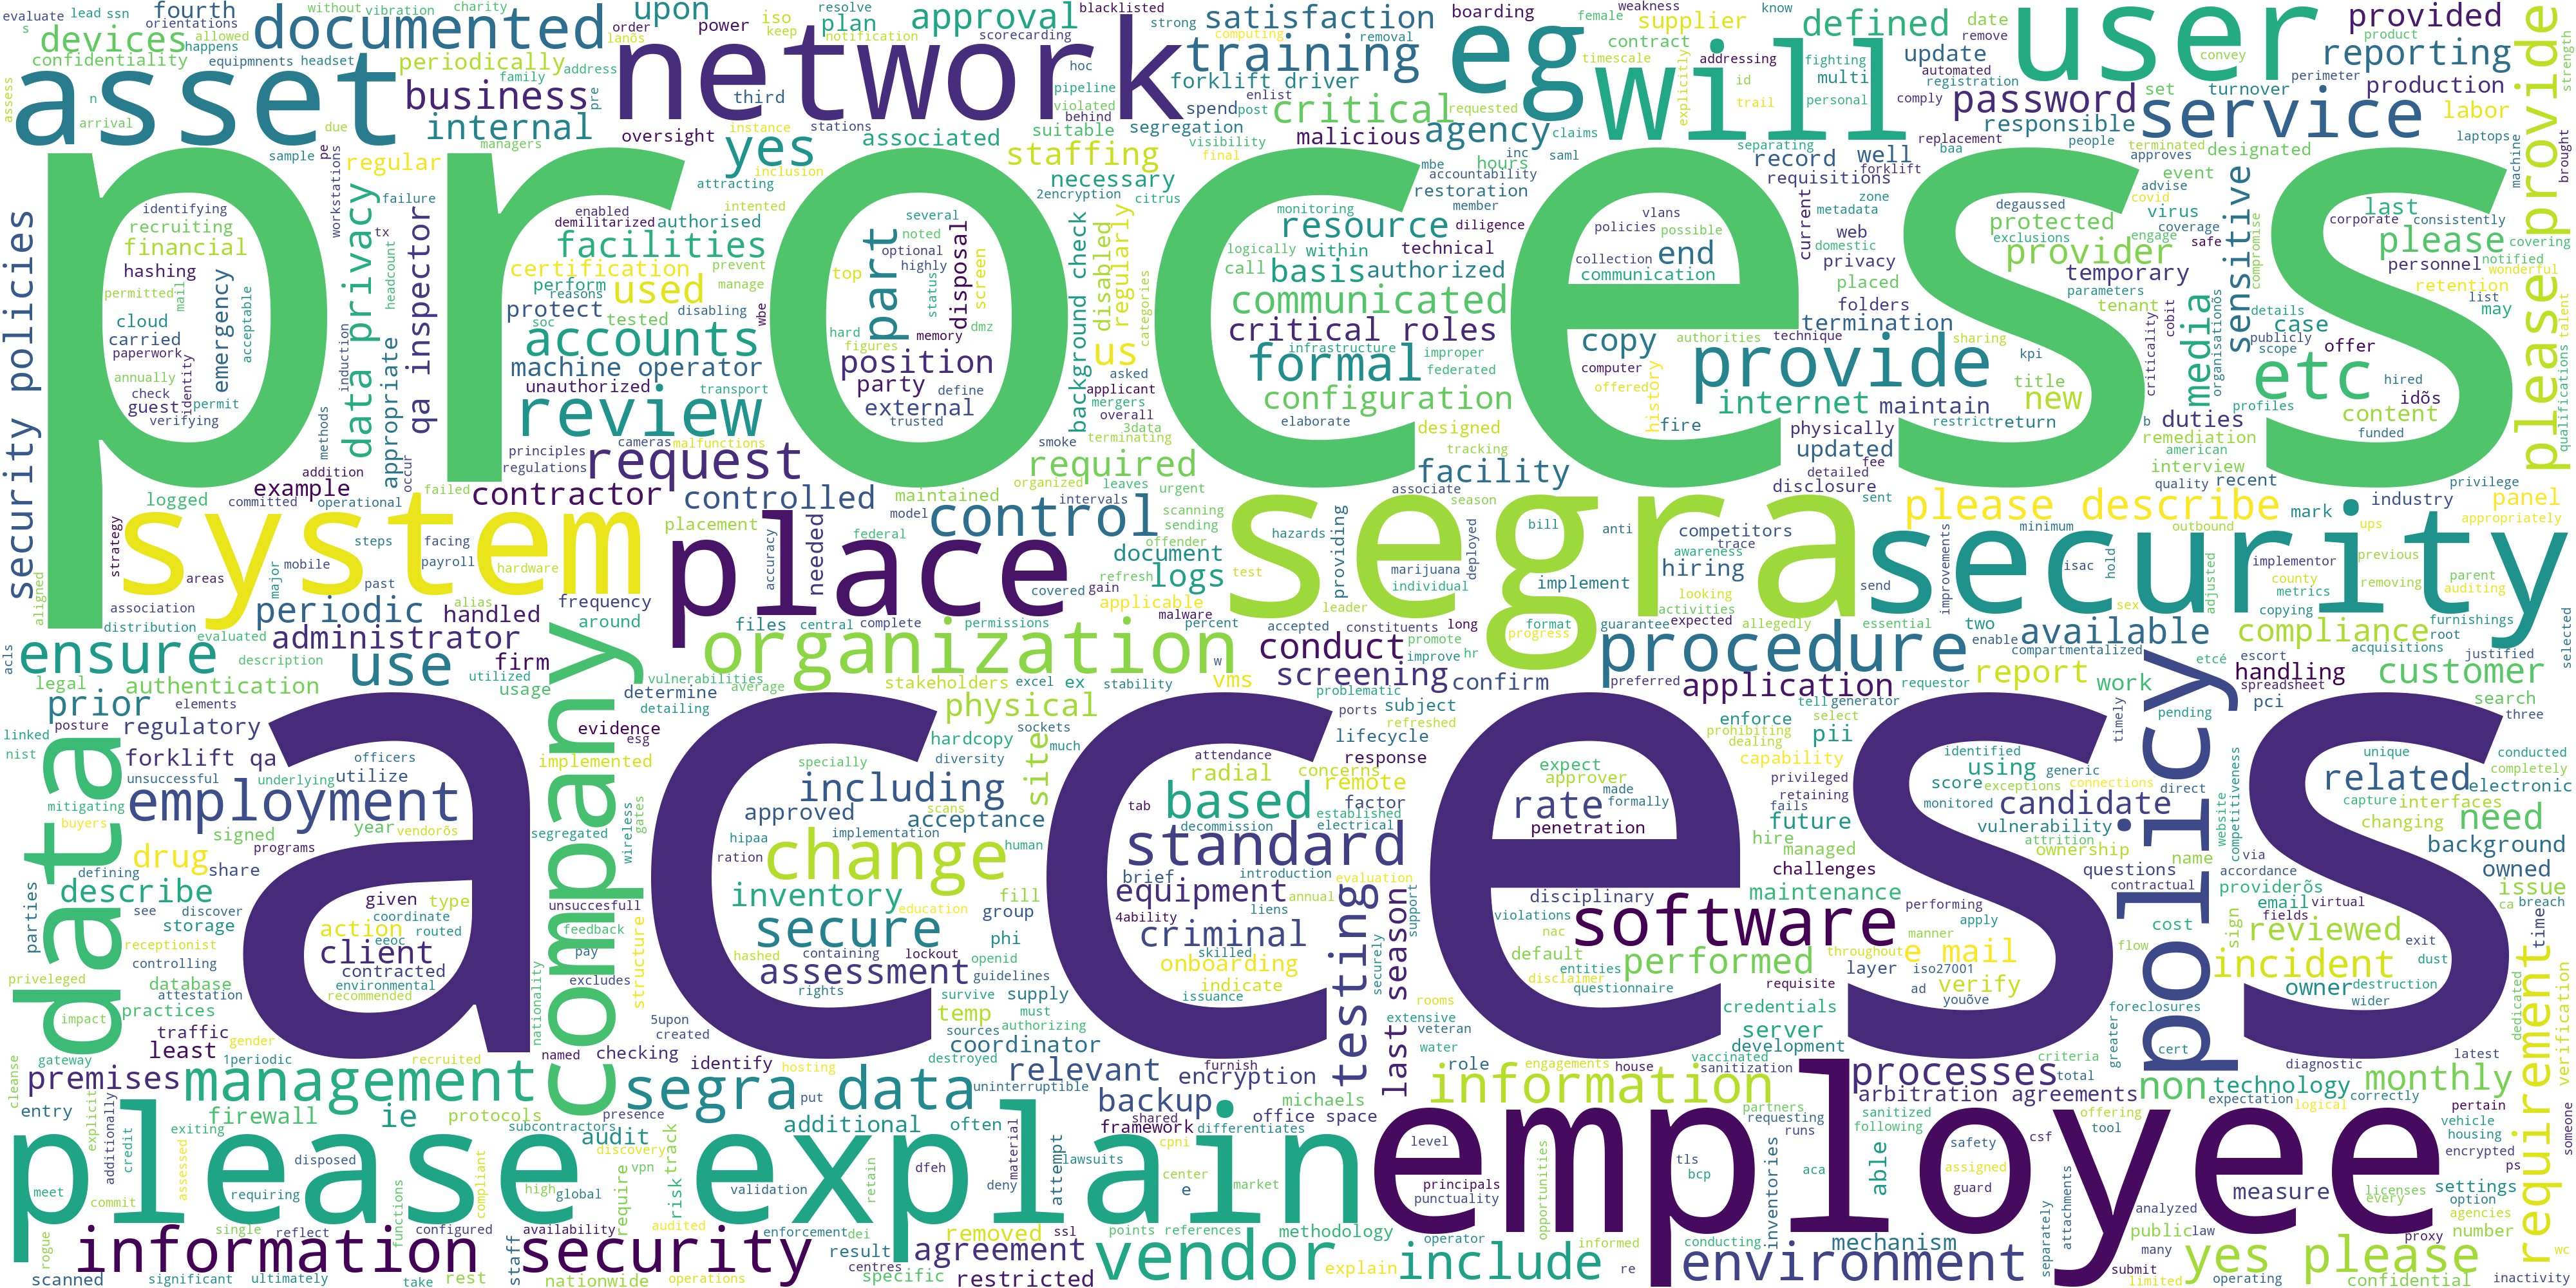

In [240]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ",".join(list(df["question_processed"].values))
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    width=4000,
    height=2000,
    max_words=5000,
    contour_width=3,
    contour_color="steelblue",
)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Vocabulary Size

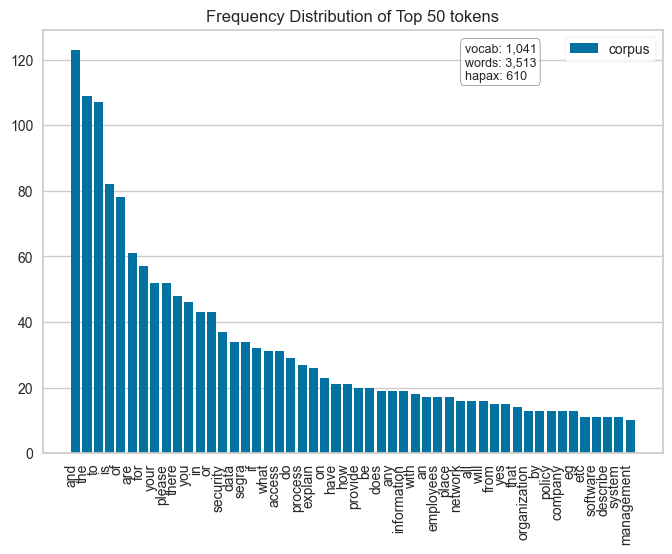

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [241]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(df["question_processed"])

features = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient="v")
visualizer.fit(docs)
visualizer.show()

In [242]:
df

question  \
0    Checking the financial stability of our suppli...   
1    How many candidates do you have in your database?   
2    How do you select which candidates are placed ...   
3    How often do you review and refresh your datab...   
4    What type of background and drug testing do yo...   
..                                                 ...   
163  \nWe require that all of our employee be vacci...   
164  \nWhat is your strategy around hiring for fork...   
165  \nDo you have a training plan for forklift dri...   
166  \nFor critical skilled positions (Forklift Dri...   
167  \nPlease explain how you keep a pipeline of cr...   

                                                answer  \
0    Our fiscal year begins in January and ends in ...   
1    As of today, 4/25/2023, we have the following:...   
2    Our specialized role known as the client speci...   
3    Our sourcing platform is updated throughout th...   
4    AccuSource is our service provider for backgro...   
..                                                 ...   
163  As part of our onboarding process for clients ...   
164  Our candidate sourcing is done through various...   
165  We do not currently offer any forklift trainin...   
166  Our designated Recruiting Specialist review th...   
167  An associate employee of Partners Personnel is...   

     partners_personnel_selected   id  question_length  question_wordcount  \
0                              0    0              182                  32   
1                              0    1               49                   9   
2                              0    2              192                  33   
3                              0    3               64                  11   
4                              0    4              135                  23   
..                           ...  ...              ...                 ...   
163                            0  163              100                  18   
164                            0  164               59                   9   
165                            0  165              129                  19   
166                            0  166              137                  19   
167                            0  167              232                  29   

     n_bundled_questions                                 question_processed  
0                      0  checking the financial stability of our suppli...  
1                      1   how many candidates do you have in your database  
2                      2  how do you select which candidates are placed ...  
3                      1  how often do you review and refresh your datab...  
4                      3  what type of background and drug testing do yo...  
..                   ...                                                ...  
163                    1  we require that all of our employee be vaccina...  
164                    1  what is your strategy around hiring for forkli...  
165                    1  do you have a training plan for forklift drive...  
166                    1  for critical skilled positions (forklift drive...  
167                    2  please explain how you keep a pipeline of crit...  

[168 rows x 8 columns]

# Duplicate / Similar Questions

In [243]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["question_processed"])
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

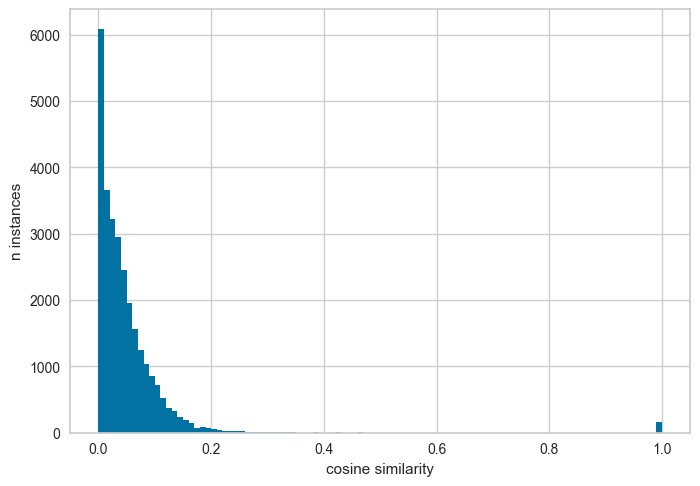

In [244]:
# distribution of cosine similarities
plt.hist(cosine_similarities.flatten(), bins=100)
plt.xlabel("cosine similarity")
plt.ylabel("n instances")
plt.show()

In [245]:
results = set()  # list of tuple pairs where (id1, id2)
for idx1, row1 in df.iterrows():
    for idx2, row2 in df.iterrows():
        if idx1 == idx2:
            continue
        sim = cosine_similarities[idx1, idx2]
        if sim < 0.3:
            continue
        results.add((idx1, idx2) if idx1 < idx2 else (idx2, idx1))

len(results), list(results)[:10]

(32,
 [(55, 148),
  (152, 166),
  (1, 3),
  (109, 110),
  (155, 156),
  (2, 8),
  (31, 53),
  (49, 71),
  (45, 58),
  (119, 120)])

In [246]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(df["question_processed"], convert_to_tensor=True)
cosine_similarities = cosine_similarity(embeddings, embeddings)

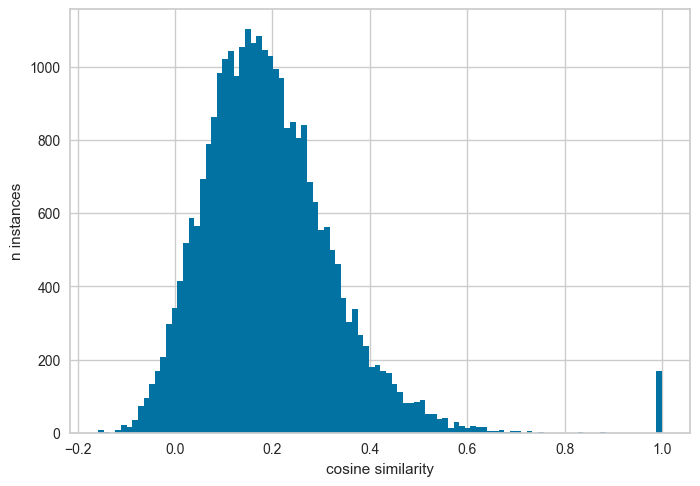

In [247]:
# distribution of cosine similarities
plt.hist(cosine_similarities.flatten(), bins=100)
plt.xlabel("cosine similarity")
plt.ylabel("n instances")
plt.show()

In [248]:
std = cosine_similarities.std()
mean = cosine_similarities.mean()

In [249]:
for idx1, row1 in df.iterrows():
    for idx2, row2 in df.iterrows():
        if idx1 == idx2:
            continue
        sim = cosine_similarities[idx1, idx2]
        if sim < mean + 3 * std:
            continue
        results.add((idx1, idx2) if idx1 < idx2 else (idx2, idx1))

len(results), list(results)[:10]

(66,
 [(91, 111),
  (164, 165),
  (108, 118),
  (31, 32),
  (55, 148),
  (25, 108),
  (71, 108),
  (121, 124),
  (152, 166),
  (1, 3)])

In [250]:
pd.DataFrame(cosine_similarities).to_csv("output/view.csv")

In [251]:
with open("output/results.txt", "w") as f:
    for idx1, idx2 in results:
        f.write(f"1 {df.iloc[idx1]['question']}\n")
        f.write(f"2 {df.iloc[idx2]['question']}\n")
        f.write("-" * 80 + "\n")

# bertopic

In [252]:
questions = [q.text for q in db.get_questions()]

In [253]:
questions[:5]

['Checking the financial stability of our suppliers is part of our due diligence process. To support us in doing this, please tell us when your company financial year runs to and from.',
 'How many candidates do you have in your database?',
 'How do you select which candidates are placed where?  For instance, if two buyers are looking for the same candidate, how do you ultimately determine which company to place that employee with?',
 'How often do you review and refresh your database of candidates?',
 'What type of background and drug testing do you conduct?  How extensive are they? Who is your service provider for background checking?']

In [254]:
# Fine-tune topic representations with GPT
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(questions)

In [255]:
topic_model.get_topic_info()

Topic  Count                                          Name  \
0     -1     74  -1_procedures_employees_termination_employee   
1      0     34     0_privacy_compliance_security_regulations   
2      1     23              1_staffing_forklift_hiring_roles   
3      2     21          2_segra_providers_protocols_services   
4      3     16   3_security_permissions_privileged_privilege   

                                      Representation  \
0  [procedures, employees, termination, employee,...   
1  [privacy, compliance, security, regulations, p...   
2  [staffing, forklift, hiring, roles, qa, placem...   
3  [segra, providers, protocols, services, backup...   
4  [security, permissions, privileged, privilege,...   

                                 Representative_Docs  
0  [Is there a process in place to ensure all emp...  
1  [Does your organization have a documented info...  
2  [If you were a provider of ours last season wh...  
3  [Is there remote access to the network and sys...  
4  [Is two factor authentication required to acce...

In [256]:
for _, row in topic_model.get_topic_info().iterrows():
    print(row["Name"], row["Count"])
    for doc in row["Representative_Docs"]:
        print(f"\t-{doc.strip()}")
    print()

-1_procedures_employees_termination_employee 74
	-Is there a process in place to ensure all employees and external users return the organization's assets on termination of their employment, contract or agreement?
	-Is there procedures in place for handling secure disposal and or return of the customer data upon request or in the case of termination of services? Please explain
	-For our CA facilities an on-site coordinator will be requested if you provide over 100 employees to our facility. For our TX facilities we will request you provide an on-site coordinator if you provide over 40 employees to our facilities.  We will provide office space, furnishings, internet access and any additional resources if needed.  The expectation of the coordinator will be attendance and arrival calls, presence in and around the production facility, address safety concerns as needed, payroll and data entry, coordinate and conduct new-hire orientations, and manage the overall headcount of Assigned Employee